## Collaborative Filtering + Matrix Factorization (Rating Prediction)
For this competition, you are tasked with categorizing shopping trip types based on the items that customers purchased. To give a few hypothetical examples of trip types: a customer may make a small daily dinner trip, a weekly large grocery trip, a trip to buy gifts for an upcoming holiday, or a seasonal trip to buy clothes.

Walmart has categorized the trips contained in this data into 38 distinct types using a proprietary method applied to an extended set of data. You are challenged to recreate this categorization/clustering with a more limited set of features. This could provide new and more robust ways to categorize trips.

The training set (train.csv) contains a large number of customer visits with the TripType included. You must predict the TripType for each customer visit in the test set (test.csv). Each visit may only have one TripType. You will not be provided with more information than what is given in the data (e.g. what the TripTypes represent or more product information).

Data fields
--> TripType (association) - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.

--> VisitNumber (unique identified) - an id corresponding to a single trip by a single customer

Weekday - the weekday of the trip

Upc - the UPC number of the product purchased

ScanCount - the number of the given item that was purchased. A negative value indicates a product return.

DepartmentDescription - a high-level description of the item's department

FinelineNumber - a more refined category for each of the products, created by Walmart

In [2]:
#Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.
#https://surpriselib.com/
!pip install scikit-surprise
!pip install xgboost

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error 
import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head(5)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TripType               647054 non-null  int64  
 1   VisitNumber            647054 non-null  int64  
 2   Weekday                647054 non-null  object 
 3   Upc                    642925 non-null  float64
 4   ScanCount              647054 non-null  int64  
 5   DepartmentDescription  645693 non-null  object 
 6   FinelineNumber         642925 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


In [5]:
train.nunique()

TripType                    38
VisitNumber              95674
Weekday                      7
Upc                      97714
ScanCount                   39
DepartmentDescription       68
FinelineNumber            5195
dtype: int64

In [6]:
#list of unique ScanCount 
print('The unique ScanCount are', sorted(train['ScanCount'].unique()))

The unique ScanCount are [-12, -10, -9, -7, -6, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 30, 31, 46, 51, 71]


In [7]:
print('The types of goods are {}'.format(train['DepartmentDescription'].nunique()))
train['DepartmentDescription'].unique()

The types of goods are 68


array(['FINANCIAL SERVICES', 'SHOES', 'PERSONAL CARE',
       'PAINT AND ACCESSORIES', 'DSD GROCERY', 'MEAT - FRESH & FROZEN',
       'DAIRY', 'PETS AND SUPPLIES', 'HOUSEHOLD CHEMICALS/SUPP', nan,
       'IMPULSE MERCHANDISE', 'PRODUCE', 'CANDY, TOBACCO, COOKIES',
       'GROCERY DRY GOODS', 'BOYS WEAR', 'FABRICS AND CRAFTS',
       'JEWELRY AND SUNGLASSES', 'MENS WEAR', 'ACCESSORIES',
       'HOME MANAGEMENT', 'FROZEN FOODS', 'SERVICE DELI',
       'INFANT CONSUMABLE HARDLINES', 'PRE PACKED DELI', 'COOK AND DINE',
       'PHARMACY OTC', 'LADIESWEAR', 'COMM BREAD', 'BAKERY',
       'HOUSEHOLD PAPER GOODS', 'CELEBRATION', 'HARDWARE', 'BEAUTY',
       'AUTOMOTIVE', 'BOOKS AND MAGAZINES', 'SEAFOOD', 'OFFICE SUPPLIES',
       'LAWN AND GARDEN', 'SHEER HOSIERY', 'WIRELESS', 'BEDDING',
       'BATH AND SHOWER', 'HORTICULTURE AND ACCESS', 'HOME DECOR', 'TOYS',
       'INFANT APPAREL', 'LADIES SOCKS', 'PLUS AND MATERNITY',
       'ELECTRONICS', 'GIRLS WEAR, 4-6X  AND 7-14', 'BRAS & SHAPEWEAR',

In [8]:
#removing missing values
train.dropna(inplace=True)

In [9]:
#deduplication 
train=train.drop_duplicates()

Exploratory Data Analysis (EDA) 
Visualization 

Text(0.5, 1.0, 'The Frequent of Department Description')

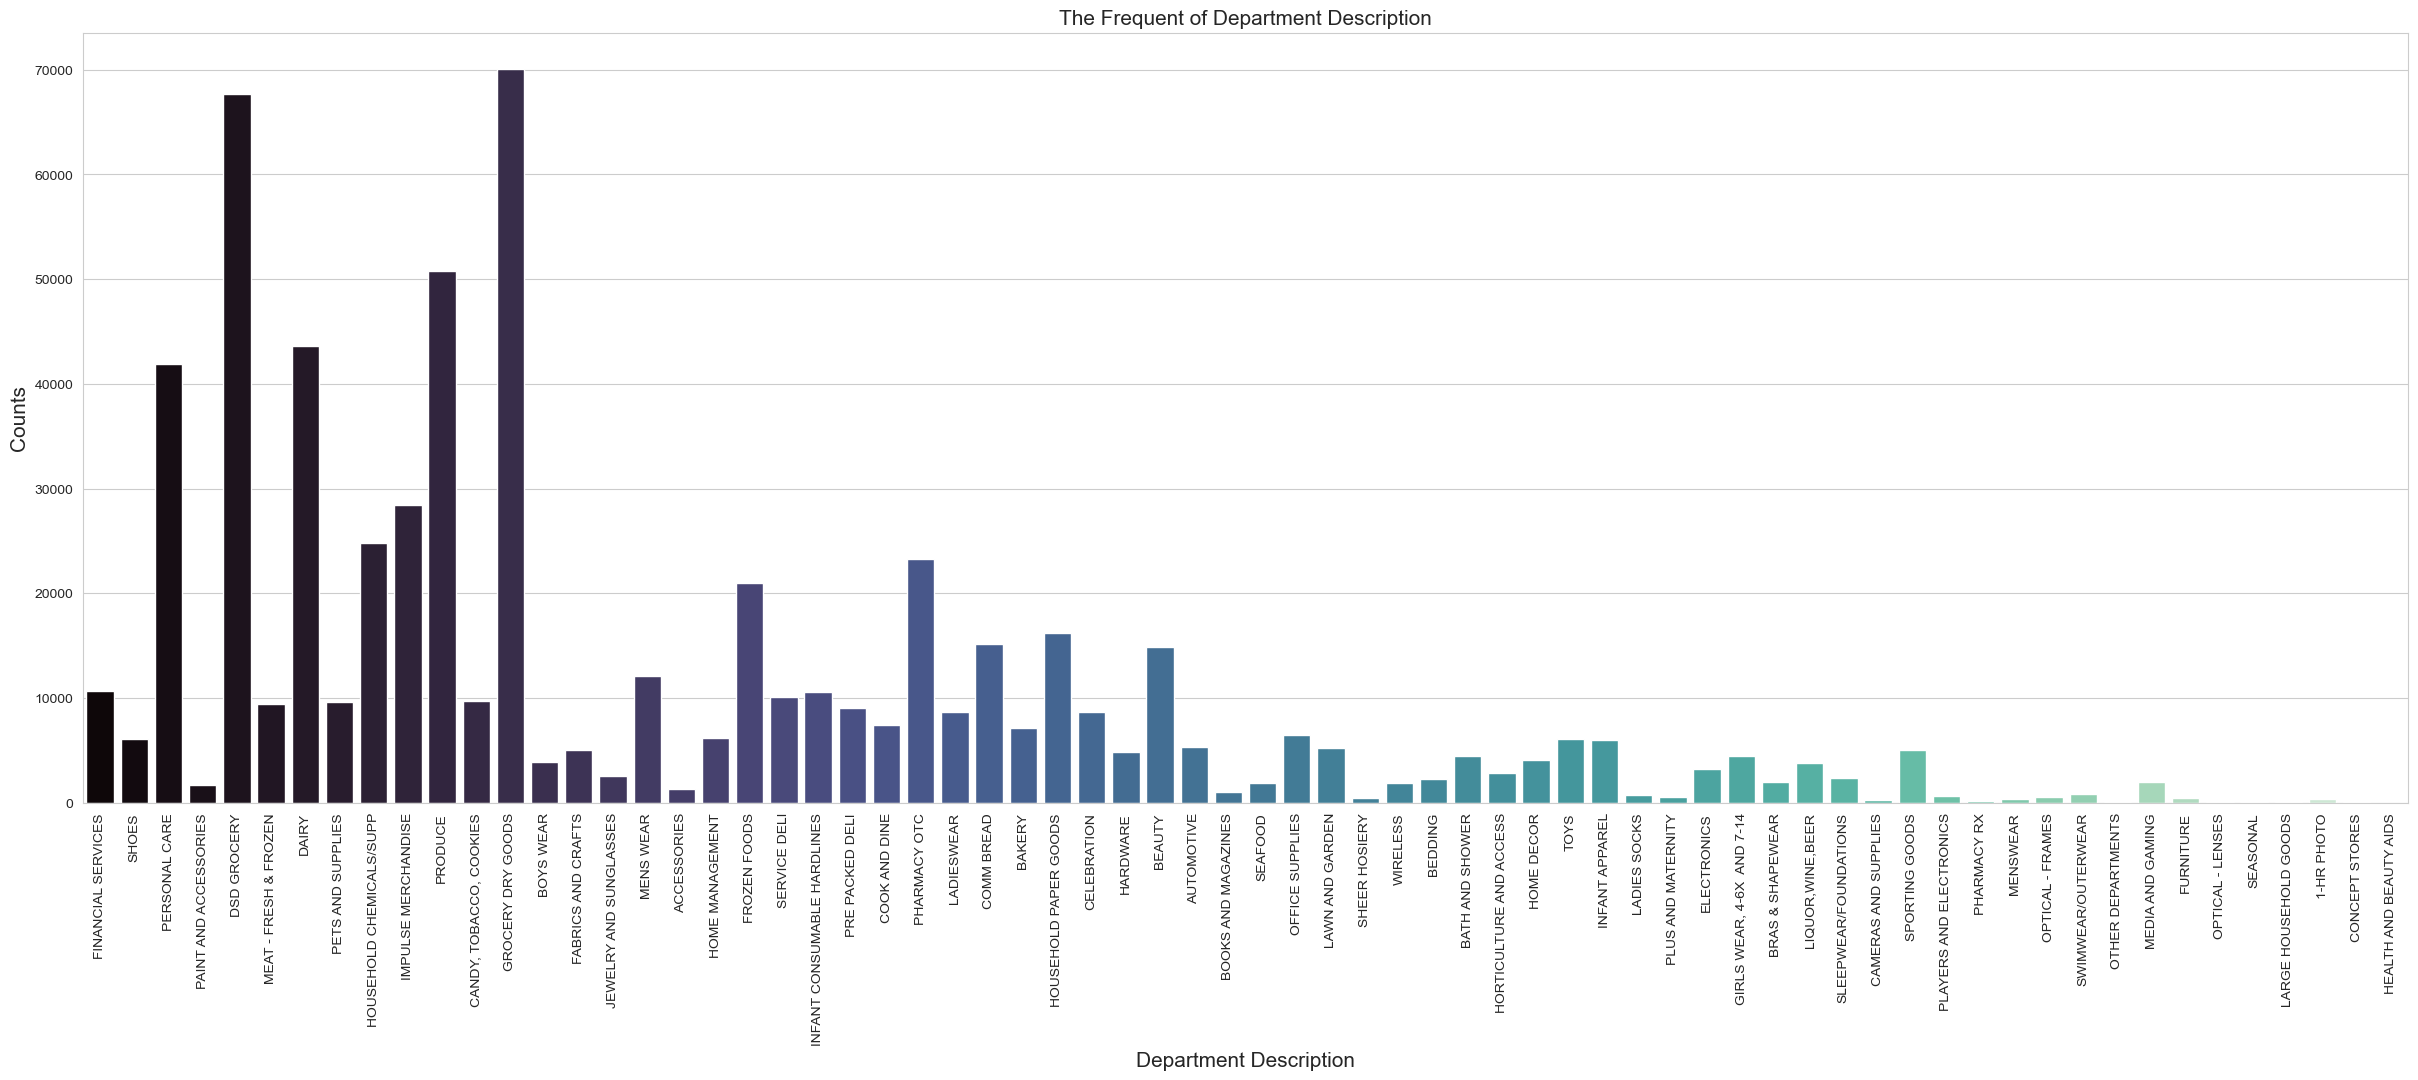

In [10]:
plt.figure(figsize = (30, 10))

sns.set_style('whitegrid')
ax1 = sns.countplot(x = 'DepartmentDescription', data = train, palette = 'mako')
plt.xticks(rotation = 90)
plt.xlabel('Department Description', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)
plt.title('The Frequent of Department Description', fontsize = 15)

Text(0.5, 1.0, 'The Frequent of TripType')

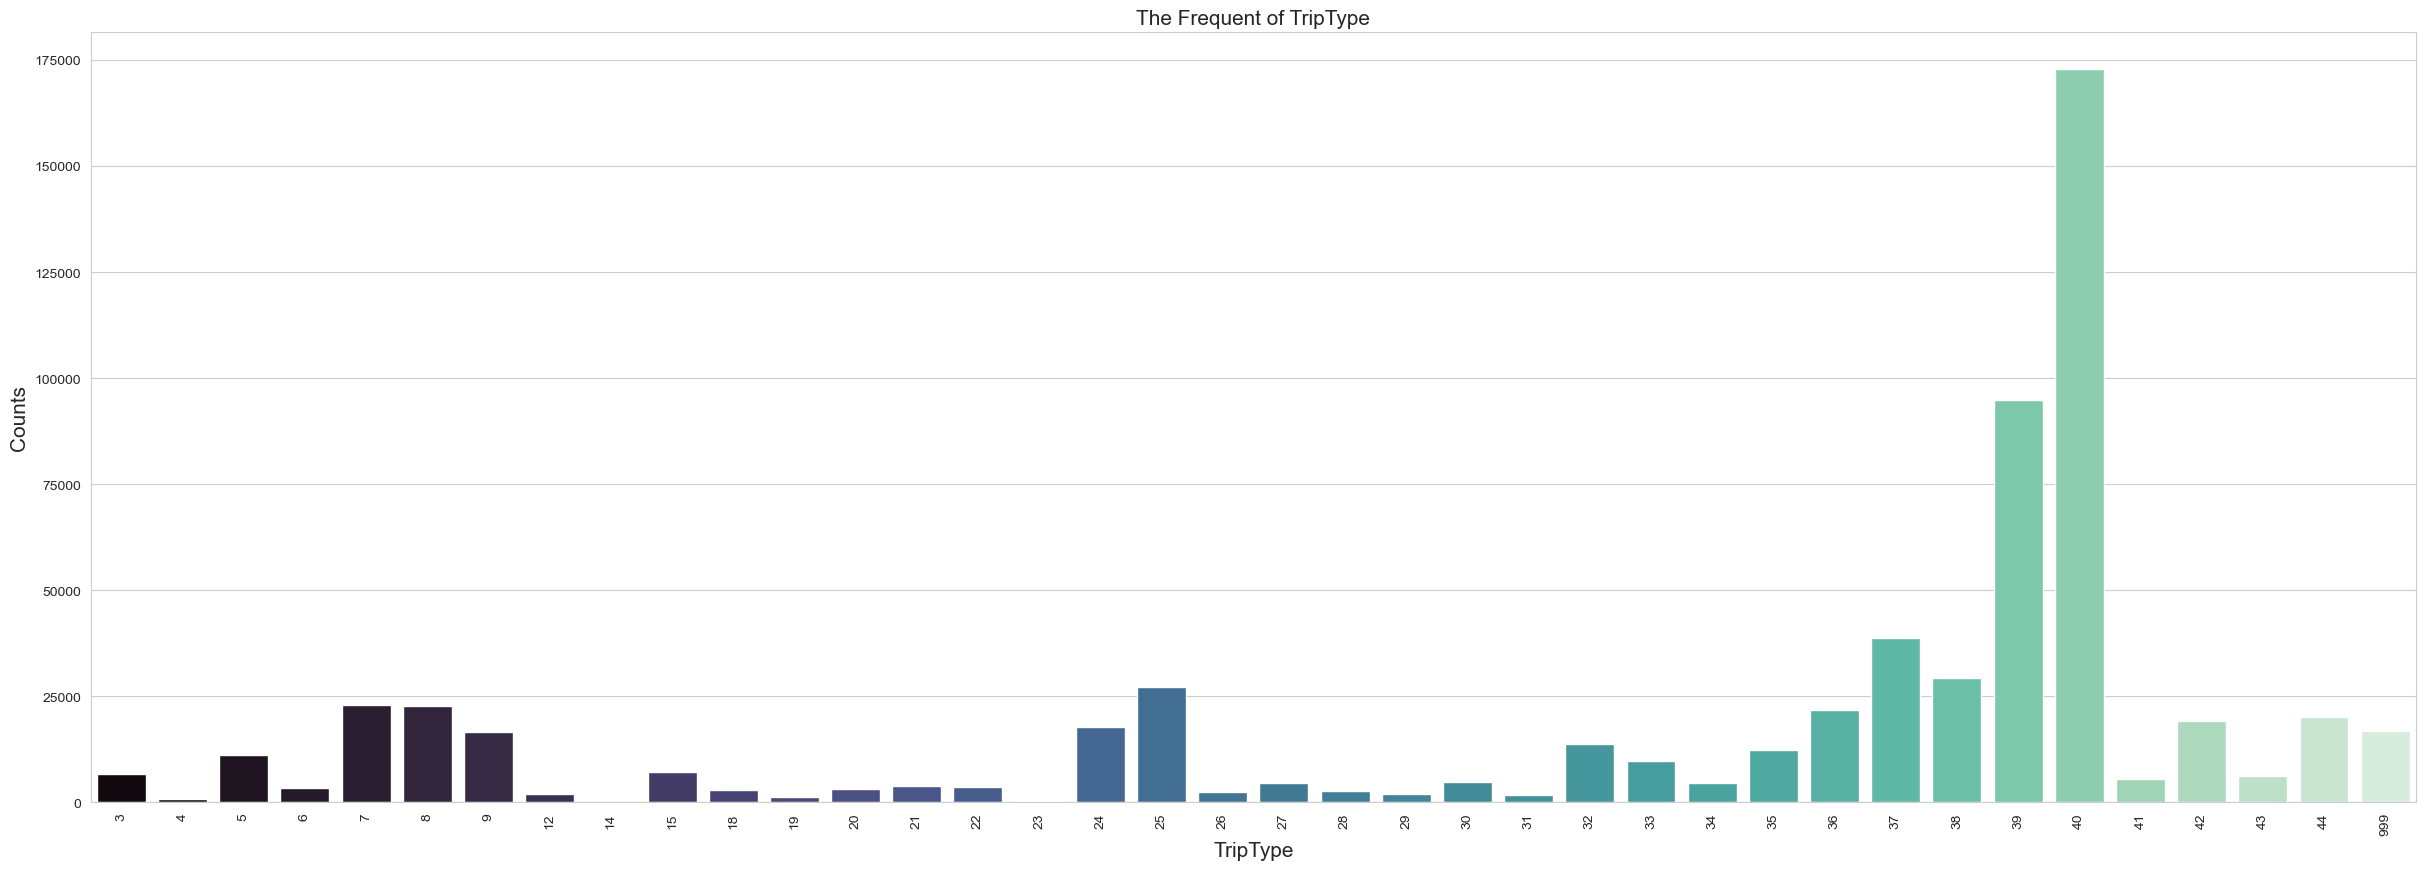

In [11]:
plt.figure(figsize = (30, 10))

sns.set_style('whitegrid')
ax1 = sns.countplot(x = 'TripType', data = train, palette = 'mako')
plt.xticks(rotation = 90)
plt.xlabel('TripType', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)
plt.title('The Frequent of TripType', fontsize = 15)

C:\Users\looi\AppData\Local\Temp\ipykernel_32316\2927824575.py:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax3 = sns.stripplot(x = 'VisitNumber', y = 'DepartmentDescription', data = train, palette = 'mako')


[Text(0.5, 1.0, 'The Correlation with VisitNumber and DepartmentDescription'),
 Text(0.5, 0, 'VisitNumber'),
 Text(0, 0.5, 'DepartmentDescription')]

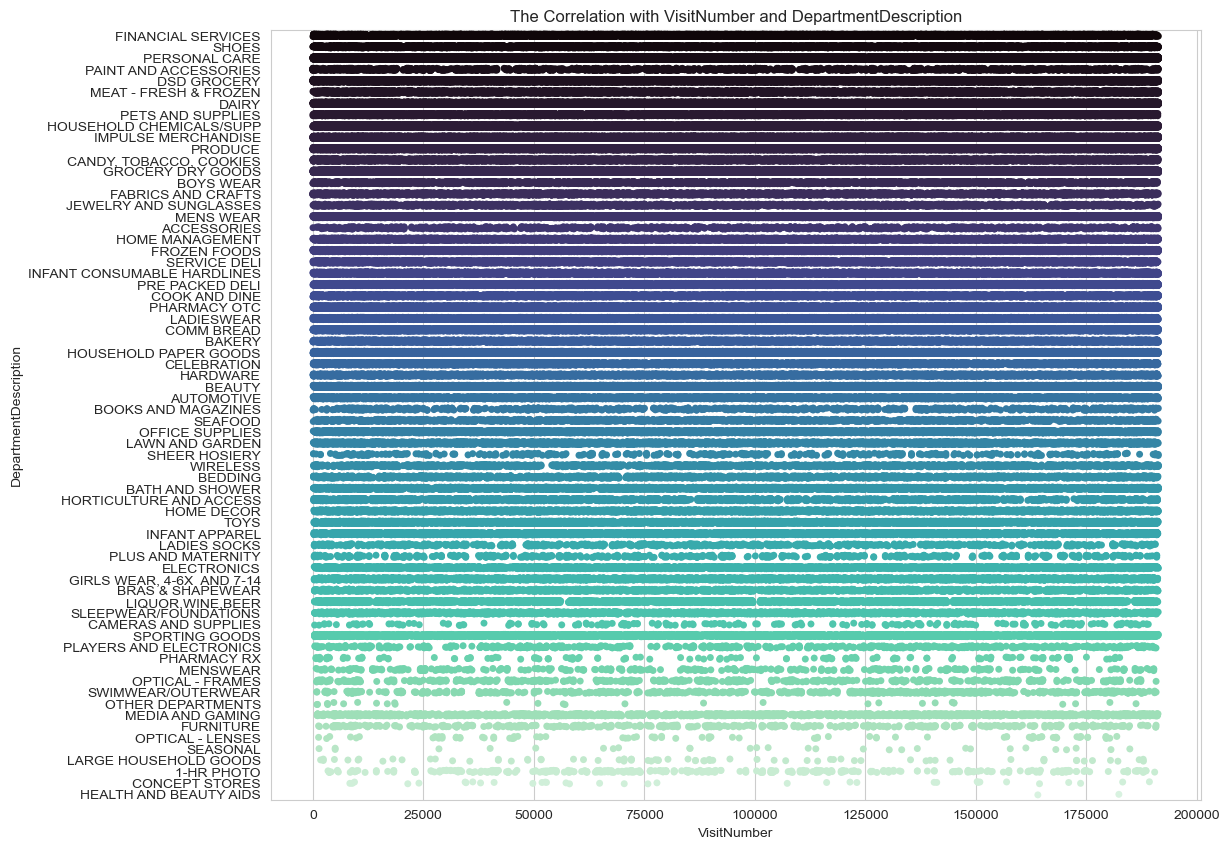

In [26]:
plt.figure(figsize = (12, 10))
sns.set_style('whitegrid')

ax3 = sns.stripplot(x = 'VisitNumber', y = 'DepartmentDescription', data = train, palette = 'mako')
ax3.set(title = 'The Correlation with VisitNumber and DepartmentDescription', xlabel = 'VisitNumber', ylabel = 'DepartmentDescription')

In [10]:
#Data preprocessing by changing the ScanCount into the scale of 1-5 
train.loc[train['ScanCount']<0,'ScanCount'] =1 
train.loc[(train['ScanCount']>1) & (train['ScanCount']<=5),'ScanCount'] =2
train.loc[(train['ScanCount']>5) & (train['ScanCount']<=10),'ScanCount'] =3
train.loc[(train['ScanCount']>10) & (train['ScanCount']<=15),'ScanCount'] =4
train.loc[train['ScanCount']>15,'ScanCount'] =5 


In [11]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [12]:
train.to_csv('preprocessing.csv',index=True)

In [13]:
#list of unique ScanCount 
print('The unique ScanCount are', sorted(train['ScanCount'].unique()))

The unique ScanCount are [1, 2, 3, 4, 5]


User-based Collaborative Filtering 

In [14]:
#Create user-item matrix 
#from sklearn.preprocessing import MinMaxScaler - one issue with MinMax (np.array)
#scaler = MinMaxScaler()
#Scaled = scaler.fit_transform(matrix)
matrix = train.pivot_table(index='VisitNumber',columns='DepartmentDescription', values='ScanCount')
matrix.head(5)

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#the dataset is simply too large to be processed, resampling to 10000 info rows 
resampled_matrix_norm = matrix_norm.head(10000)

In [17]:
# User similarity matrix using Pearson correlation
user_similarity = resampled_matrix_norm.T.corr()
user_similarity.head()

VisitNumber,5,7,8,9,10,11,12,15,17,19,...,20106,20108,20109,20120,20121,20127,20128,20129,20130,20132
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#pick a visit number 
picked_visitnumber = 8

#remove picked visit bumber from the candidate list 
user_similarity.drop(index=picked_visitnumber, inplace=True)

#take a look at the data
user_similarity.head()

VisitNumber,5,7,8,9,10,11,12,15,17,19,...,20106,20108,20109,20120,20121,20127,20128,20129,20130,20132
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#number of similar users
n = 10 

#user similarity threshold
user_similarity_threshold = 0.3

#get top n similar users
similar_users = user_similarity[user_similarity[picked_visitnumber]>user_similarity_threshold][picked_visitnumber].sort_values(ascending=False)[:n]

#print out top n similar users
print(f'The similar users for user {picked_visitnumber} are', similar_users)

The similar users for user 8 are VisitNumber
4414     1.0
199      1.0
14645    1.0
14581    1.0
14508    1.0
14482    1.0
14233    1.0
14196    1.0
14134    1.0
14058    1.0
Name: 8, dtype: float64


Narrow down item pool 

In [21]:
# Department that the visit_number has visited
picked_visitnumber_department = resampled_matrix_norm[resampled_matrix_norm.index == picked_visitnumber].dropna(axis=1, how='all')
picked_visitnumber_department

DepartmentDescription,DAIRY,DSD GROCERY,HOUSEHOLD CHEMICALS/SUPP,MEAT - FRESH & FROZEN,PAINT AND ACCESSORIES,PETS AND SUPPLIES
VisitNumber,,,,,,
8,0.6875,-0.3125,-0.3125,-0.3125,0.0625,0.1875


In [22]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_department = resampled_matrix_norm[resampled_matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_department

DepartmentDescription,AUTOMOTIVE,BAKERY,BEAUTY,BOOKS AND MAGAZINES,"CANDY, TOBACCO, COOKIES",COMM BREAD,DAIRY,DSD GROCERY,FROZEN FOODS,GROCERY DRY GOODS,...,INFANT CONSUMABLE HARDLINES,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PRE PACKED DELI,PRODUCE,SEAFOOD,SERVICE DELI
VisitNumber,,,,,,,,,,,,,,,,,,,,,
199,NaN,NaN,NaN,NaN,NaN,NaN,0.222222,NaN,NaN,-0.111111,...,NaN,NaN,-0.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4414,NaN,NaN,NaN,NaN,NaN,-0.010989,0.131868,-0.010989,NaN,-0.010989,...,NaN,-0.010989,-0.010989,NaN,NaN,-0.010989,-0.010989,-0.010989,-0.010989,-0.010989
14058,-0.222222,NaN,0.277778,NaN,NaN,-0.222222,0.777778,-0.222222,NaN,-0.222222,...,NaN,NaN,NaN,NaN,NaN,-0.222222,NaN,NaN,NaN,NaN
14134,NaN,0.859343,NaN,NaN,NaN,NaN,-0.015657,-0.140657,NaN,0.081566,...,-0.140657,NaN,NaN,-0.140657,NaN,-0.140657,-0.140657,0.059343,NaN,NaN
14196,NaN,-0.250000,NaN,NaN,NaN,-0.250000,0.750000,-0.250000,0.000000,-0.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,NaN,NaN
14233,NaN,NaN,NaN,NaN,NaN,-0.125000,NaN,-0.125000,NaN,NaN,...,NaN,NaN,NaN,NaN,0.375,NaN,-0.125000,NaN,NaN,NaN
14482,NaN,-0.083333,NaN,NaN,-0.083333,NaN,0.166667,NaN,NaN,-0.083333,...,NaN,-0.083333,-0.083333,NaN,NaN,NaN,0.416667,NaN,NaN,NaN
14508,NaN,NaN,NaN,-0.190741,NaN,-0.190741,0.059259,-0.190741,0.409259,0.475926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009259,NaN,NaN
14581,NaN,NaN,NaN,NaN,NaN,NaN,0.200000,NaN,0.700000,-0.300000,...,NaN,NaN,NaN,NaN,-0.300,NaN,NaN,-0.300000,NaN,NaN


In [23]:
# Remove the picked_visitnumber_department from the picked_visitnumber_department list
similar_user_department.drop(picked_visitnumber_department.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar_user_department

DepartmentDescription,AUTOMOTIVE,BAKERY,BEAUTY,BOOKS AND MAGAZINES,"CANDY, TOBACCO, COOKIES",COMM BREAD,FROZEN FOODS,GROCERY DRY GOODS,HOME MANAGEMENT,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT CONSUMABLE HARDLINES,"LIQUOR,WINE,BEER",PERSONAL CARE,PHARMACY OTC,PRE PACKED DELI,PRODUCE,SEAFOOD,SERVICE DELI
VisitNumber,,,,,,,,,,,,,,,,,,,
199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4414,NaN,NaN,NaN,NaN,NaN,-0.010989,NaN,-0.010989,NaN,-0.010989,NaN,NaN,-0.010989,NaN,-0.010989,-0.010989,-0.010989,-0.010989,-0.010989
14058,-0.222222,NaN,0.277778,NaN,NaN,-0.222222,NaN,-0.222222,NaN,0.277778,NaN,NaN,NaN,NaN,-0.222222,NaN,NaN,NaN,NaN
14134,NaN,0.859343,NaN,NaN,NaN,NaN,NaN,0.081566,NaN,-0.140657,NaN,-0.140657,NaN,-0.140657,-0.140657,-0.140657,0.059343,NaN,NaN
14196,NaN,-0.250000,NaN,NaN,NaN,-0.250000,0.000000,-0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,NaN,NaN
14233,NaN,NaN,NaN,NaN,NaN,-0.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.125000,NaN,NaN,NaN
14482,NaN,-0.083333,NaN,NaN,-0.083333,NaN,NaN,-0.083333,-0.083333,-0.083333,NaN,NaN,-0.083333,NaN,NaN,0.416667,NaN,NaN,NaN
14508,NaN,NaN,NaN,-0.190741,NaN,-0.190741,0.409259,0.475926,NaN,-0.190741,NaN,NaN,NaN,NaN,NaN,NaN,0.009259,NaN,NaN
14581,NaN,NaN,NaN,NaN,NaN,NaN,0.700000,-0.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.300000,NaN,NaN


Recommend departments
We will decide which movie to recommend to the target user. The recommended items are determined by the weighted average of user similarity score and movie rating. The movie ratings are weighted by the similarity scores, so the users with higher similarity get higher weights.

This code loops through items and users to get the item score, rank the score from high to low and pick the top 10 movies to recommend to user ID 1.

In [24]:
# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_department.columns:
  # Get the ratings for movie i
  Scan_count = similar_user_department[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(Scan_count[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * Scan_count[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['Department', 'Score'])
    
# Sort the movies by score
ranked_item_score = item_score.sort_values(by='Score', ascending=False)

# Select top m movies
m = 10
ranked_item_score.head(m)

,Department,Score
6,FROZEN FOODS,0.369753
1,BAKERY,0.175337
2,BEAUTY,0.122222
15,PRE PACKED DELI,0.035005
16,PRODUCE,-0.004287
17,SEAFOOD,-0.010989
18,SERVICE DELI,-0.022161
9,HOUSEHOLD PAPER GOODS,-0.030213
10,IMPULSE MERCHANDISE,-0.033333
12,"LIQUOR,WINE,BEER",-0.047161


Rating Prediction

In [29]:
#import library --> don't mix up with sklearn (machine learnnig) & surprise (Matrix factorization)
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics import precision_score, roc_auc_score
from sklearn.metrics import average_precision_score

In [30]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(train[['VisitNumber','DepartmentDescription','ScanCount']], reader)
data


In [31]:
trainSet, testSet = train_test_split(data, test_size=0.30, random_state=42)
algo= SVD(random_state=42)
algo.fit(trainSet)
predictions= algo.test(testSet)


In [36]:
from collections import defaultdict

In [44]:
k = 10
top_k_predictions = defaultdict(list)
for uid, iid, true_r, est, _ in predictions:
    top_k_predictions[uid].append((iid, est))

precision = []
recall = []
average_precision = []

In [43]:
for uid, user_preds in top_k_predictions.items():
    user_preds.sort(key=lambda x: x[1], reverse=True)
    true_ks = [iid for (iid, _) in user_preds][:k]
    hits = np.in1d(true_ks, [iid for (iid, _) in user_preds])
    precision.append(np.sum(hits) / min(k, len(user_preds)))
    recall.append(np.sum(hits) / len(user_preds))
    average_precision.append(np.sum(hits * np.cumsum(hits) / np.arange(1, len(hits) + 1)) / min(k, len(user_preds)))

mean_precision = np.mean(precision)
mean_recall = np.mean(recall)
mean_average_precision = np.mean(average_precision)

# Print the evaluation results
print("Precision at", k, ":", mean_precision)
print("Recall at", k, ":", mean_recall)
print("Mean Average Precision:", mean_average_precision)

Precision at 15 : 1.0
Recall at 15 : 0.9982919066170346
Mean Average Precision: 1.0


In [22]:
def MAE(predictions):
        return accuracy.mae(predictions, verbose=False)
def RMSE(predictions):
        return accuracy.rmse(predictions, verbose=False)
    
print("RMSE:", RMSE(predictions))
print("MAE:", MAE(predictions))

RMSE: 0.3207906748193675
MAE: 0.19590240790147145


In [33]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, average_precision_score
from sklearn.preprocessing import LabelBinarizer

# Extract the true ratings and predicted ratings
true_ratings = [pred.r_ui for pred in predictions]
pred_ratings = [pred.est for pred in predictions]

# Binarize the predicted ratings using thresholding
threshold = 0.5
pred_ratings_binary = [int(round(r) > threshold) for r in pred_ratings]

# Calculate accuracy
accuracy = accuracy_score(true_ratings, pred_ratings_binary)
print("Accuracy score:", accuracy)

# Convert true ratings to binary form using LabelBinarizer
lb = LabelBinarizer()
true_ratings = lb.fit_transform(true_ratings)

# Convert predicted ratings to binary form using thresholding
pred_ratings_binary = np.array(pred_ratings_binary).reshape(-1, 1)
pred_ratings_binary = lb.transform(pred_ratings_binary)

# Calculate AUC
auc_score = roc_auc_score(true_ratings, pred_ratings_binary)
print("AUC score:", auc_score)

# Calculate precision
pred_labels = lb.inverse_transform(pred_ratings_binary)
true_labels = lb.inverse_transform(true_ratings)
precision_score = precision_score(true_labels, pred_labels, average='weighted')
print("Precision score:", precision_score)


Accuracy score: 0.8913815246786606
AUC score: 0.5
Precision score: 0.7945610225384536


C:\Users\looi\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# Reshape the data
true_ratings = np.array(true_ratings).reshape(-1, 1)
pred_ratings = np.array(pred_ratings).reshape(-1, 1)


# Calculate MAP
map_score = average_precision_score(true_ratings, pred_ratings)
print("Mean Average Precision (MAP):", map_score)

ValueError: Found input variables with inconsistent numbers of samples: [957710, 191542]

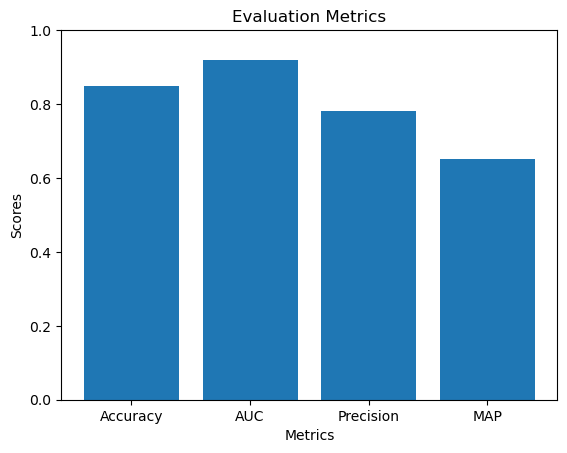

In [32]:
# Example metric scores
accuracy = 0.85
auc_score = 0.92
precision_score = 0.78
map_score = 0.65

# Create a bar plot
metrics = ['Accuracy', 'AUC', 'Precision', 'MAP']
scores = [accuracy, auc_score, precision_score, map_score]

plt.bar(metrics, scores)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Metrics')
plt.ylim([0, 1])  # Set the y-axis range
plt.show()